Topic Modeling TripAdvisor Hotel Reviews (20k)
kasus:
Datast yang berisi usulan pelanggan hotel flatform TripAdvisor.
Tujuan daripada ini untuk menganalisis tema atau topik utama yang sering di bicarakan pelanggan. contoh kebersihan, lokasi, pelayanan dan lain2.

Penjelasan Kolom:


*   Reveiw : text ulasan pengguna
*   Rating : sekor 1 sampai 5 menggambarkan tingkat kepuasan



In [3]:
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/Colab-Notebooks/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [4]:
!kaggle datasets list -s "TripAdvisor-Hotel-Reviews-20k-Dataset"

ref                                                title                                        size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-------------------------------------------------  -------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
andrewmvd/trip-advisor-hotel-reviews               Trip Advisor Hotel Reviews                5386190  2020-09-30 08:31:20.757000          43240        559  1.0              
arnabchaki/tripadvisor-reviews-2023                Tripadvisor Reviews 2023 ⭐               22844947  2023-05-17 08:26:35.217000           2566         45  1.0              
shoumikdhar/tripadvisor-hotel-reviews-20k-dataset  TripAdvisor Hotel Reviews 20k Dataset     5386190  2022-09-12 10:55:35.337000            120          3  0.29411766       


In [5]:
!kaggle datasets download -d shoumikdhar/tripadvisor-hotel-reviews-20k-dataset

Dataset URL: https://www.kaggle.com/datasets/shoumikdhar/tripadvisor-hotel-reviews-20k-dataset
License(s): unknown
  0% 0.00/5.14M [00:00<?, ?B/s]
100% 5.14M/5.14M [00:00<00:00, 395MB/s]


In [6]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Topic Modeling
from sklearn.decomposition import LatentDirichletAllocation

# Misc
import re
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [7]:
!unzip tripadvisor-hotel-reviews-20k-dataset.zip

Archive:  tripadvisor-hotel-reviews-20k-dataset.zip
  inflating: tripadvisor_hotel_reviews.csv  


In [8]:
!cat tripadvisor_hotel_reviews.csv

Output streaming akan dipotong hingga 5000 baris terakhir.
"seasons not perfect stayed night service facilities good just annoying things marred experience, welcome letter personally addressed hand-written nice touch difficult spell surname right 3 letters long, forgive not follows, week returning home uk received letter say taken pack playing cards minibar debited s 11 credit card, not not taken cards n't play cards no time short stay play cards, appointed hotel bored play cards wonder, perspective s 11 petty money, hotel millions turn pursue small, personally not justify expending time cost long-distance phone singapore refund s 11, emailed seasons international website promised reply 48 hours, 4 weeks later silence nada, think mere 11 seasons paid lot ruining reputation,  ",2
"not faulted, stayed christmas 2005 experience not better, hotel staff credit 4 seasons minutes staff knew names went way book restaurants local attractions pashmina wrap, air-con strong afternoon tea location 

Data Understanding

Jumlah baris & kolom: (20491, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB
None
Panjang rata-rata setiap review: 724.896832755844
Jumlah duplikat: 0
Review    0
Rating    0
dtype: int64


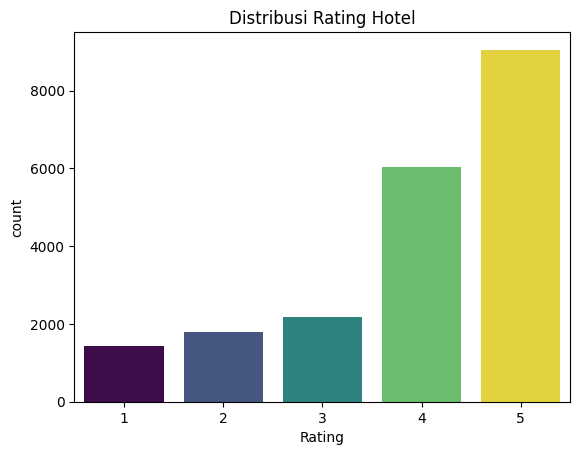

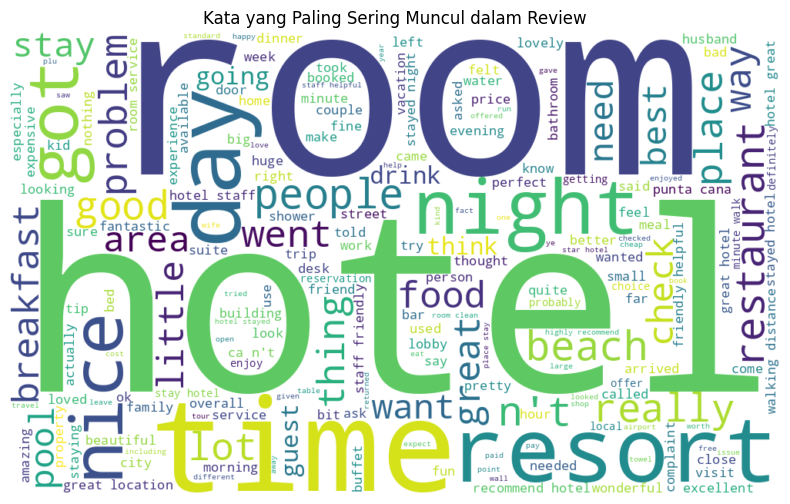

In [15]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')

# Jumlah baris dan kolom
print("Jumlah baris & kolom:", df.shape)

# Cek kolom
print(df.info())

# Panjang rata-rata teks review
avg_length = df['Review'].str.len().mean()
print("Panjang rata-rata setiap review:", avg_length)

# Cek duplikasi
print("Jumlah duplikat:", df.duplicated().sum())

# Cek data kosong
print(df.isnull().sum())

# Distribusi rating
sns.countplot(data=df, x='Rating', hue='Rating', palette='viridis', legend=False)
plt.title("Distribusi Rating Hotel")
plt.show()

# Word Cloud untuk kata paling sering muncul
text = " ".join(df['Review'].astype(str))
wc = WordCloud(width=1000, height=600, background_color='white').generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Kata yang Paling Sering Muncul dalam Review")
plt.show()

Data Text Processing

In [17]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    return " ".join(text)

df['clean_review'] = df['Review'].apply(clean_text)

df[['Review', 'clean_review']].head()


Review  \
0  nice hotel expensive parking got good deal sta...   
1  ok nothing special charge diamond member hilto...   
2  nice rooms not 4* experience hotel monaco seat...   
3  unique, great stay, wonderful time hotel monac...   
4  great stay great stay, went seahawk game aweso...   

                                        clean_review  
0  nice hotel expensive parking got good deal sta...  
1  ok nothing special charge diamond member hilto...  
2  nice room experience hotel monaco seattle good...  
3  unique great stay wonderful time hotel monaco ...  
4  great stay great stay went seahawk game awesom...

Text Vectorization

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
X = vectorizer.fit_transform(df['clean_review'])


print("Shape matrix:", X.shape)


Shape matrix: (20491, 8159)


Topic Modeling (LDA)

In [19]:
num_topics = 5

lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# Tampilkan topik dan kata kunci
words = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda_model.components_):
    print(f"\nTopik {idx+1}:")
    print([words[i] for i in topic.argsort()[-10:][::-1]])



Topik 1:
['beach', 'resort', 'food', 'room', 'great', 'good', 'pool', 'day', 'time', 'restaurant']

Topik 2:
['room', 'hotel', 'night', 'desk', 'day', 'told', 'time', 'stay', 'service', 'bed']

Topik 3:
['hotel', 'room', 'good', 'location', 'night', 'nice', 'great', 'stay', 'bed', 'breakfast']

Topik 4:
['hotel', 'great', 'room', 'staff', 'location', 'stay', 'breakfast', 'stayed', 'clean', 'helpful']

Topik 5:
['hotel', 'stay', 'service', 'room', 'staff', 'pool', 'beach', 'view', 'restaurant', 'day']


/tmp/ipython-input-1007867116.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Dominant_Topic', data=df, palette='magma')


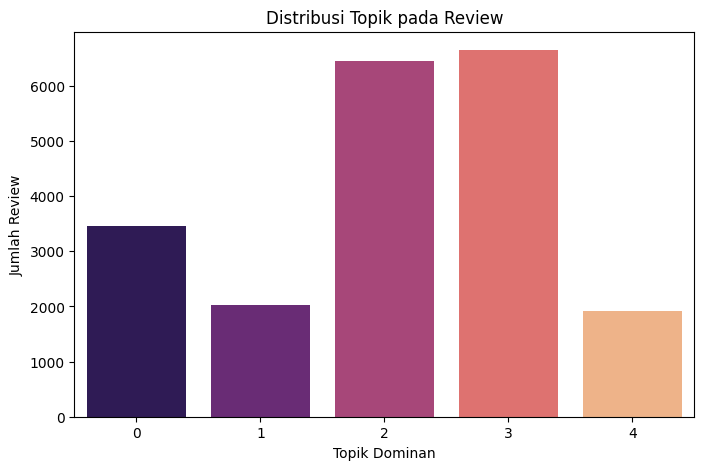

Review  Dominant_Topic
0  nice hotel expensive parking got good deal sta...               2
1  ok nothing special charge diamond member hilto...               1
2  nice rooms not 4* experience hotel monaco seat...               1
3  unique, great stay, wonderful time hotel monac...               2
4  great stay great stay, went seahawk game aweso...               1
5  love monaco staff husband stayed hotel crazy w...               2
6  cozy stay rainy city, husband spent 7 nights m...               2
7  excellent staff, housekeeping quality hotel ch...               1
8  hotel stayed hotel monaco cruise, rooms genero...               2
9  excellent stayed hotel monaco past w/e delight...               3

In [20]:
topic_values = lda_model.transform(X)
df['Dominant_Topic'] = topic_values.argmax(axis=1)

# Distribusi topik
plt.figure(figsize=(8,5))
sns.countplot(x='Dominant_Topic', data=df, palette='magma')
plt.title("Distribusi Topik pada Review")
plt.xlabel("Topik Dominan")
plt.ylabel("Jumlah Review")
plt.show()


df[['Review', 'Dominant_Topic']].head(10)


/tmp/ipython-input-217752986.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dominant_Topic', y='Rating', data=df, palette='cool')


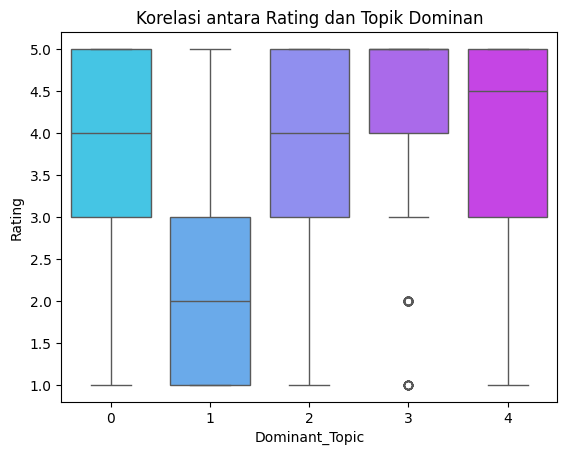

In [21]:
sns.boxplot(x='Dominant_Topic', y='Rating', data=df, palette='cool')
plt.title("Korelasi antara Rating dan Topik Dominan")
plt.show()


In [22]:
df.groupby('Dominant_Topic')['Rating'].mean().sort_values(ascending=False)


Dominant_Topic
3    4.645307
4    3.967675
0    3.888116
2    3.825325
1    2.173999
Name: Rating, dtype: float64

Visualisasi LDA hasil Topic Modeling dengan PCA

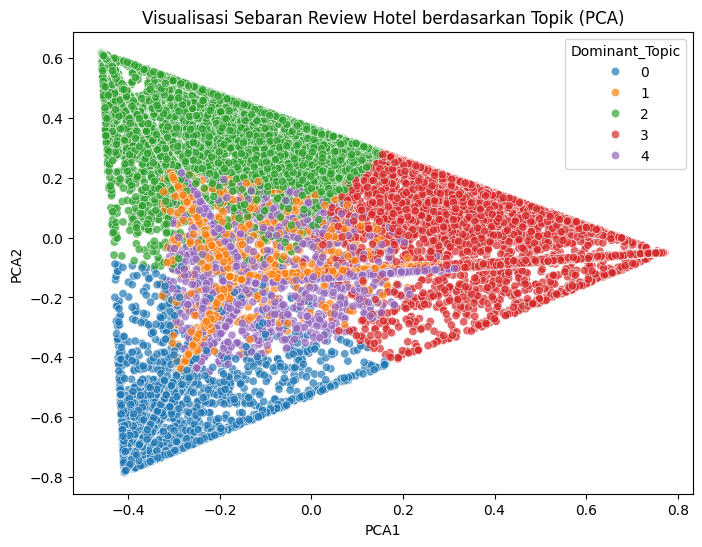

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


lda_topics = lda_model.transform(X)

dominant_topic = lda_topics.argmax(axis=1)

# Reduksi dimensi ke 2D pakai PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(lda_topics)

# Buat DataFrame
import pandas as pd
df_pca = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'Dominant_Topic': dominant_topic
})

# Visualisasi
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='Dominant_Topic',
    palette='tab10',
    alpha=0.7
)
plt.title('Visualisasi Sebaran Review Hotel berdasarkan Topik (PCA)')
plt.show()